In [3]:
%matplotlib inline
from skimage import graph, data, io, segmentation, color
from matplotlib import pyplot as plt
from skimage.measure import regionprops
from skimage import draw
import numpy as np
import json
import base64
import matplotlib.image as mpimg
from skimage import color
from matplotlib import pyplot as plt

In [4]:
def normalize_image(image):
    a = np.min(image)
    b = np.max(image)
    return (image - a) / (b - a)

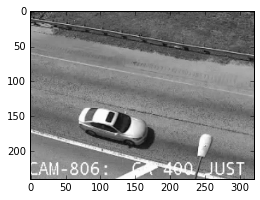

In [5]:
import io
jf = json.loads(open('cams/cam806/frames/cam806_1.json').read())
image = color.rgb2gray(mpimg.imread(io.BytesIO(base64.b64decode(jf['frame'])),format='png'))
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')

In [20]:
from skimage import graph, data, io, segmentation, color
import scipy.ndimage
def loadframes(frames):
    for f in frames:
        img = color.rgb2gray(io.imread(f)) 
        yield img.flat

In [21]:
import glob   
path = 'cams/cam806/frames/*.png'   
frames=glob.glob(path)

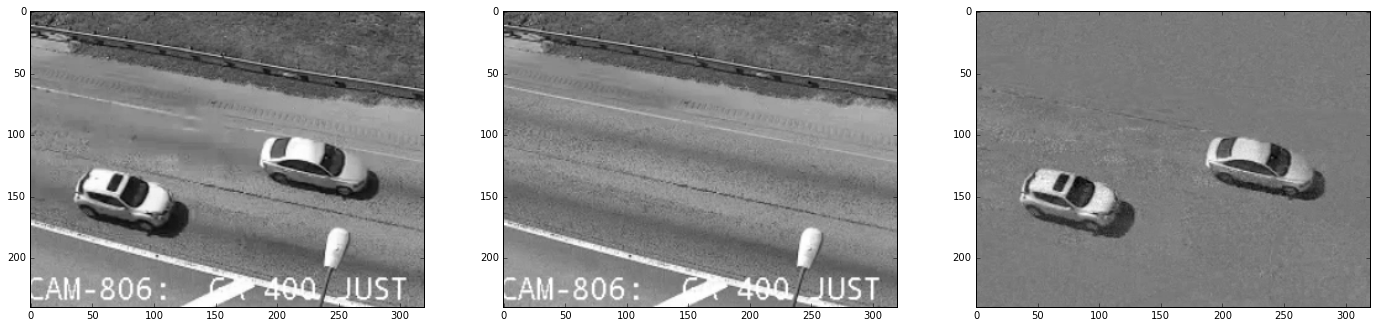

In [153]:
F = np.column_stack(loadframes(frames))
F_med = np.median(F, axis=1)
F_med_img = F_med.reshape(240,320)
img = np.subtract(F[:,30],F_med).reshape(240,320)
plt.figure(figsize=(24, 24))
plt.subplot(131)
plt.imshow(F[:,30].reshape(240,320), cmap='gray')
plt.subplot(132)
plt.imshow(F_med_img, cmap='gray')
plt.subplot(133)
plt.imshow(img, cmap='gray')

# Thresholding

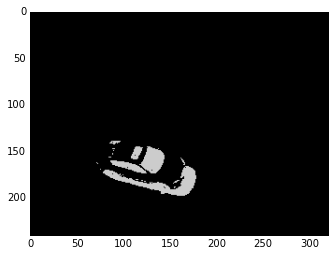

In [36]:
from skimage import filters
img = np.subtract(F[:,1],F_med).reshape(240,320)
threshold = filters.threshold_isodata(img)
mask1 = img < threshold
plt.imshow(mask1, cmap='spectral')
plt.show()

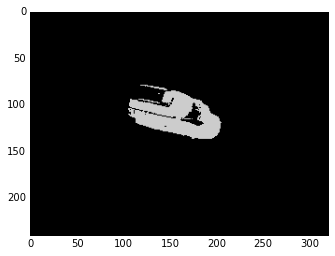

In [37]:
img = np.subtract(F[:,29],F_med).reshape(240,320)
threshold = filters.threshold_isodata(img)
mask2 = img < threshold
plt.imshow(mask2, cmap='spectral')
plt.show()

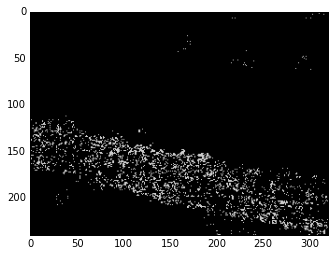

In [38]:
img = np.subtract(F[:,15],F_med).reshape(240,320)
threshold = filters.threshold_isodata(img)
mask3 = img < threshold
plt.imshow(mask3, cmap='spectral')
plt.show()

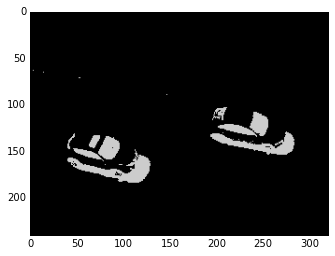

In [39]:
img = np.subtract(F[:,30],F_med).reshape(240,320)
threshold = filters.threshold_isodata(img)
mask4 = img < threshold
plt.imshow(mask4, cmap='spectral')
plt.show()

Estimated number of clusters: 2


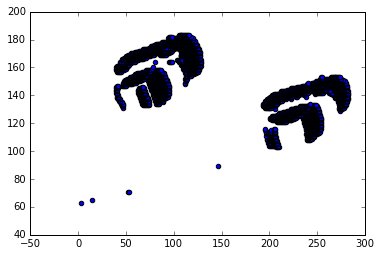

In [135]:
X = np.argwhere(mask4)

from sklearn.cluster import DBSCAN
from sklearn import metrics
plt.scatter(X[:,1],X[:,0])
db = DBSCAN(eps=20, min_samples=10).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

In [148]:
img=F[:,30].reshape(240,320)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
labels = db.labels_
X_labels = np.vstack((X[:,0],X[:,1],labels)).T
rows, cols = img.shape
color_mask = np.zeros((rows, cols, 3))
for i,c in enumerate(set(labels)):
    if c >= 0:
        X_c = X[(X_labels[:,2] == c)]
        if len(X_c) > 0:
            print X_c.shape
            minx = np.min(X_c[:,0])
            maxx = np.max(X_c[:,0])
            miny = np.min(X_c[:,1])
            maxy = np.max(X_c[:,1])
            # Construct a colour image to superimpose
            color_mask[minx:maxx, miny:maxy] = [1, 0, 0]  # Red block
color_mask_hsv = color.rgb2hsv(color_mask)

(1546, 2)
(1733, 2)


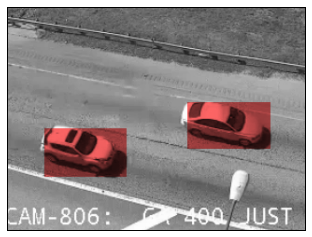

In [149]:
from skimage import data, color, io, img_as_float

alpha = 0.6

# Construct RGB version of grey-level image
img_color = np.dstack((img, img, img))

# Convert the input image to Hue Saturation Value (HSV)
# colorspace
img_hsv = color.rgb2hsv(img_color)

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

img_masked = color.hsv2rgb(img_hsv)

# Display the output
f, ax1 = plt.subplots(1, 1, subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img_masked)

In [56]:
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap


cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

def plot_dbscan(X):

    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(X)
    clusters

    fig, axes = plt.subplots(3, 4, figsize=(11, 8),
                             subplot_kw={'xticks': (), 'yticks': ()})
    # Plot clusters as red, green and blue, and outliers (-1) as white
    colors = [cm3(1), cm3(0), cm3(2)]
    markers = ['o', '^', 'v']

    # iterate over settings of min_samples and eps
    for i, min_samples in enumerate([10, 20, 30]):
        for j, eps in enumerate([10, 15, 20, 25]):
            # instantiate DBSCAN with a particular setting
            dbscan = DBSCAN(min_samples=min_samples, eps=eps)
            # get cluster assignments
            clusters = dbscan.fit_predict(X)
            print("min_samples: %d eps: %f  cluster: %s"
                  % (min_samples, eps, clusters))
            if np.any(clusters == -1):
                c = ['w'] + colors
                m = ['o'] + markers
            else:
                c = colors
                m = markers
            discrete_scatter(X[:, 0], X[:, 1], clusters, ax=axes[i, j], c=c,
                             s=8, markers=m)
            inds = dbscan.core_sample_indices_
            # vizualize core samples and clusters.
            if len(inds):
                discrete_scatter(X[inds, 0], X[inds, 1], clusters[inds],
                                 ax=axes[i, j], s=15, c=colors,
                                 markers=markers)
            axes[i, j].set_title("min_samples: %d eps: %.1f"
                                 % (min_samples, eps))
    fig.tight_layout()

min_samples: 10 eps: 10.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 10 eps: 15.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 10 eps: 20.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 10 eps: 25.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 20 eps: 10.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 20 eps: 15.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 20 eps: 20.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 20 eps: 25.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 30 eps: 10.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 30 eps: 15.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 30 eps: 20.000000  cluster: [-1 -1 -1 ...,  1  1  1]
min_samples: 30 eps: 25.000000  cluster: [-1 -1 -1 ...,  1  1  1]


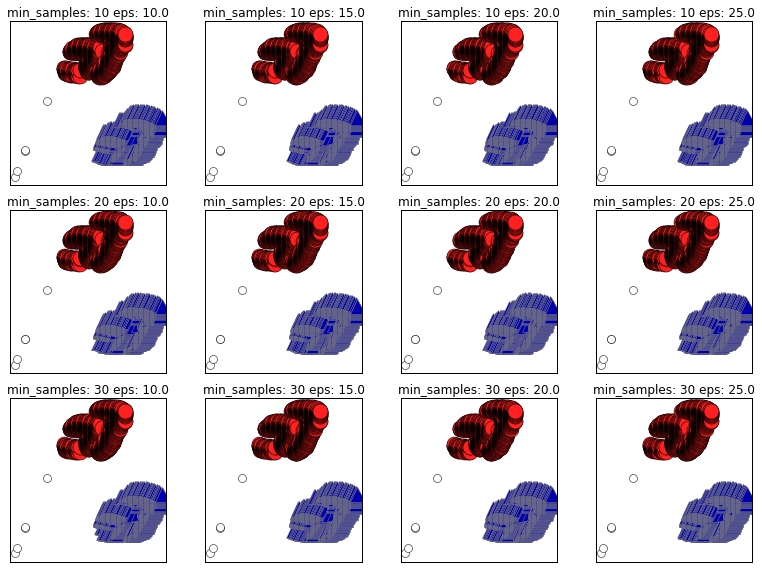

In [137]:
import matplotlib as mpl
plot_dbscan(X)

In [55]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines